In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import boxcox

from imp import load_source

from sklearn.decomposition import PCA

import aggregate_player_stats as aps

query_strings = load_source('query_strings', '../stats_generation/query_strings.py' )
gps = load_source(  'generate_player_stats', '../stats_generation/generate_player_stats.py' )

In [4]:
%matplotlib inline
plt.style.use('dark_background')
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10

First generate stuff for the whole team

In [50]:
n_weeks = 4

# Generate aggregate of team statistics from preseason and regular season
team_stats_df = aps.aggregate_pre_reg_team_stats( 2017 )

# Get sums from previous games
prev_team     = aps.calc_prev_stats( team_stats_df, team_stats_df.columns.values[4:], n_weeks )

# Combine the present values with the recent averages
team_stats_df = pd.merge( team_stats_df, prev_team, on=['team','year','week'] )

# Drop all the preseason stuff
team_stats_df = team_stats_df.loc[ team_stats_df['week']>0 ]

# Null it out
prev_team     = 0

# Note if the data includes preseason stuff
# If the first four games, flag as preseason data included
# This is tricky, as can have a bye-week
# Therefore, group things, find the first n_weeks, and flag those as 1
inds = team_stats_df.groupby(['team','year'], as_index=False).nth( range(0,n_weeks) ).index.values

team_stats_df    [       'includes_preseason'] = 0
team_stats_df.loc[ inds, 'includes_preseason'] = 1

In [3]:
all_team_data = pd.DataFrame()

# Get all the team data
# Can id by team, week, year
for year in range( 2009, 2017 ):
    new_frame = gps.generate_stats( 'Team', year )
    new_frame['year'] = year
    all_team_data = pd.concat( [all_team_data, new_frame], ignore_index=True )
    
# Create new df
edited_df = all_team_data[['team','opp_team','week','year', 'score', 'opp_score', 'home_flag', 'away_flag','tds']].copy()


# Offense


# General offensive play breakdowns
#  Have these features, plus make the commented ones
#edited_df['pass_play_frac' ] = all_team_data['pass_att'] / ( all_team_data['pass_att'] + all_team_data['rush_att'] )
#edited_df['off_plays'      ] = all_team_data['pass_att'] +   all_team_data['rush_att']
#edited_df['pass_cmp_frac'  ] = all_team_data['pass_cmp'] /   all_team_data['pass_att']
#edited_df['pass_sack_frac' ] = all_team_data['pass_sack']/   all_team_data['pass_att']
#edited_df['rush_yds_avg'   ] = all_team_data['rush_yds'] /   all_team_data['rush_att']
#edited_df['pass_yds_avg'   ] = all_team_data['pass_yds'] /   all_team_data['pass_att']
edited_df['rush_att' ] = all_team_data['rush_att']
edited_df['rush_yds' ] = all_team_data['rush_yds']
edited_df['pass_att' ] = all_team_data['pass_att']
edited_df['pass_yds' ] = all_team_data['pass_yds']
edited_df['pass_cmp' ] = all_team_data['pass_cmp']
edited_df['pass_sack'] = all_team_data['pass_sack']



# Get info onto offense effectiveness
#  Create features
#edited_df['frac_score_drives'] = all_team_data['kickoffs'] / ( all_team_data['kickoffs'] + 
#                                                               all_team_data['punts'   ] + 
#                                                               all_team_data['fg_miss' ] )
edited_df['kickoffs'] = all_team_data['kickoffs']
edited_df['punts'   ] = all_team_data['punts'   ]
edited_df['fg_miss' ] = all_team_data['fg_miss' ]


# How well off keeps the ball
edited_df['fumbles'         ] = all_team_data['off_fumb_tot'   ]



# Kickoffs that land far,
#  Create w/in 20 yd line or touchbacks
#edited_df['frac_far_kickoffs'] = ( all_team_data['kickoff_in_20'] + 
#                                   all_team_data['kickoff_touchback'] ) / all_team_data['kickoffs']
edited_df['kickoff_in_20'    ] = all_team_data['kickoff_in_20']
edited_df['kickoff_touchback'] = all_team_data['kickoff_touchback']


# How good they are at putting in the kicker
# And how far that is
# Create feature
#edited_df['fg_yds_avg'  ] = all_team_data['fg_yds' ] / all_team_data['fg_made']
edited_df['fg_yds' ] = all_team_data['fg_yds' ]
edited_df['fg_made'] = all_team_data['fg_made']
edited_df['fg_miss'] = all_team_data['fg_miss']

# No fg made, just go with median
#edited_df['fg_yds_avg'].fillna( edited_df['fg_yds_avg'].median() , inplace=True )


# Defense

# How many scores total
scored_stuff = ['def_int_tds','def_frec_tds','def_misc_tds','def_safety']
edited_df['def_score_flag'] = 0
edited_df.loc[all_team_data[scored_stuff].sum(axis=1)>0,'def_score_flag'] = 1

# Can defense do a good job one on one, 
#  or does whole D need to tackle one guy
#edited_df['solo_tkl_frac'] = all_team_data['def_tkl']/all_team_data['def_tkl_contributers']
edited_df['def_tkl'] = all_team_data['def_tkl']
edited_df['def_tkl_contributers'] = all_team_data['def_tkl_contributers']

# Defensive turnovers, just take 2
def_turn = [u'def_fumb_forced', u'def_int']
edited_df[def_turn] = all_team_data[def_turn]



# Pressure
def_hits = [u'def_tkl_loss','def_sack', 'def_pass_def']
edited_df[def_hits] = all_team_data[def_hits].astype(int)


# Stuff to consider from opposing team
opp_team_stuff = [
                  'rush_att', 
                  'rush_yds', 
                  'pass_att',
                  'pass_yds', 
                  'pass_cmp', 
                  'pass_sack', 
                  'kickoffs', 
                  'punts', 
                  'fumbles', 
                  'def_tkl', 
                  'def_tkl_contributers',
                  'def_sack',
                  'def_pass_def'
                 ]

# Rename opposing team stuff
renamed_frame = edited_df[[u'week', 'year']].copy()
renamed_frame['opp_team'] = edited_df['team']
for col in opp_team_stuff:
    renamed_frame['opp_'+col] = edited_df[col]

# Add the opposing team stuff
team_df = pd.merge( edited_df, 
                    renamed_frame, 
                    how='left', 
                    left_on=['opp_team','week','year'],
                    right_on=['opp_team','week','year'], )
team_df.head(20)

,team,opp_team,week,year,score,opp_score,home_flag,away_flag,tds,rush_att,...,opp_pass_yds,opp_pass_cmp,opp_pass_sack,opp_kickoffs,opp_punts,opp_fumbles,opp_def_tkl,opp_def_tkl_contributers,opp_def_sack,opp_def_pass_def
0,ARI,SF,1,2009,16.0,20.0,1,0,1,17,...,209,18,4,5,8,1,10,52,3,8
1,ARI,JAC,2,2009,31.0,17.0,0,1,4,28,...,282,23,4,4,4,4,0,51,0,1
2,ARI,IND,3,2009,10.0,31.0,1,0,1,12,...,379,24,0,6,4,1,12,56,4,6
3,ARI,HOU,5,2009,28.0,21.0,1,0,4,16,...,371,35,0,4,5,1,10,44,1,6
4,ARI,SEA,6,2009,27.0,3.0,0,1,3,26,...,154,11,5,2,8,2,3,64,2,4
5,ARI,NYG,7,2009,24.0,17.0,0,1,3,22,...,243,19,3,4,7,2,21,46,2,9
6,ARI,CAR,8,2009,21.0,34.0,1,0,3,17,...,90,7,1,7,6,0,12,52,2,14
7,ARI,CHI,9,2009,41.0,21.0,0,1,5,31,...,369,29,4,4,4,0,11,59,1,2
8,ARI,SEA,10,2009,31.0,20.0,1,0,4,30,...,331,27,4,5,7,0,8,59,0,3
9,ARI,STL,11,2009,21.0,13.0,0,1,3,30,...,215,19,3,4,4,2,4,58,2,2


In [23]:
print junk['def_pass_def'].head()
print all_team_data['def_pass_def'].head()

0    5
1    3
2    5
3    3
4    8
Name: def_pass_def, dtype: int64
0    5
1    3
2    5
3    3
4    8
Name: def_pass_def, dtype: int64


Next, generate kicker statistics

In [8]:
all_kicker_data = pd.DataFrame()

# Get all the team data
# Can id by team, week, year
for year in range( 2009, 2017 ):
    new_frame = gps.generate_stats( 'K', year )
    new_frame['year'] = year
    all_kicker_data = pd.concat( [all_kicker_data, new_frame], ignore_index=True )
    
# Ignore some team stuff, can get from joining with team
all_kicker_data = all_kicker_data.drop( ['opp_team','home_flag','away_flag'],axis=1 )

In [9]:
all_kicker_data.head(20)

,player_id,team,week,xp_made,xp_miss,fg_made,fg_miss,fg_made_yds,fg_miss_yds,fg_made_max,fg_miss_min,year
0,00-0004091,CLE,1,1,0,2,0,57,0,37,NaN,2009
1,00-0004091,CLE,2,0,0,2,0,69,0,47,NaN,2009
2,00-0004091,CLE,8,0,1,0,0,0,0,0,NaN,2009
3,00-0004091,CLE,10,0,0,0,0,0,0,0,NaN,2009
4,00-0004091,CLE,11,3,0,2,0,73,0,44,NaN,2009
5,00-0004091,CLE,12,1,0,0,0,0,0,0,NaN,2009
6,00-0004091,CLE,13,2,0,1,1,49,43,49,43.0,2009
7,00-0004091,CLE,14,1,0,2,0,58,0,29,NaN,2009
8,00-0004091,CLE,15,5,0,2,1,77,52,47,52.0,2009
9,00-0004091,CLE,16,2,0,3,0,109,0,42,NaN,2009


In [17]:
foo.head(20)

,xp_made,xp_miss,fg_made,fg_miss,fg_made_yds,fg_miss_yds,fg_made_max,fg_miss_min,fg_made_yds_avg,fg_made_minus_avg
0,1,0,2,0,57,0,37,NaN,28.500000,NaN
1,0,0,2,0,69,0,47,NaN,34.500000,NaN
2,0,1,0,0,0,0,0,NaN,NaN,NaN
3,0,0,0,0,0,0,0,NaN,NaN,NaN
4,3,0,2,0,73,0,44,NaN,36.500000,NaN
5,1,0,0,0,0,0,0,NaN,NaN,NaN
6,2,0,1,1,49,43,49,43.0,49.000000,6.0
7,1,0,2,0,58,0,29,NaN,29.000000,NaN
8,5,0,2,1,77,52,47,52.0,38.500000,-13.5
9,2,0,3,0,109,0,42,NaN,36.333333,NaN


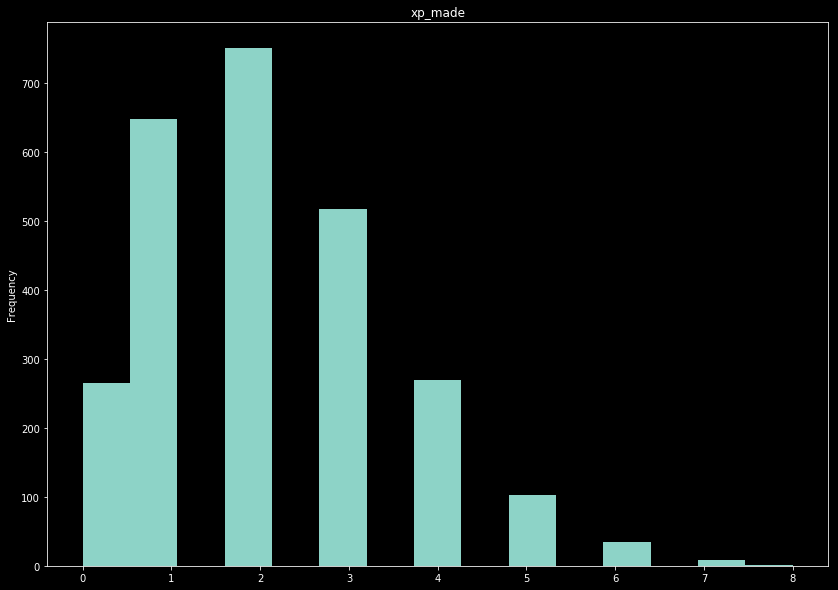

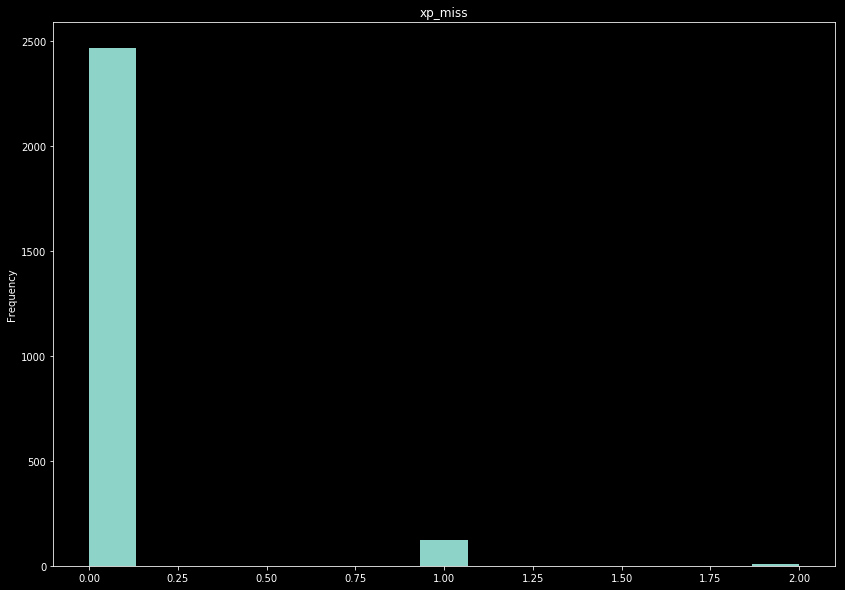

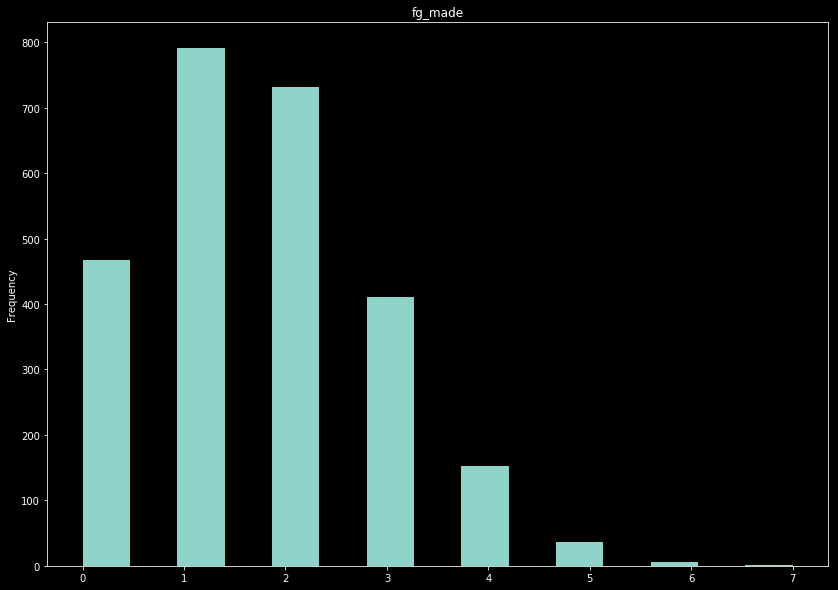

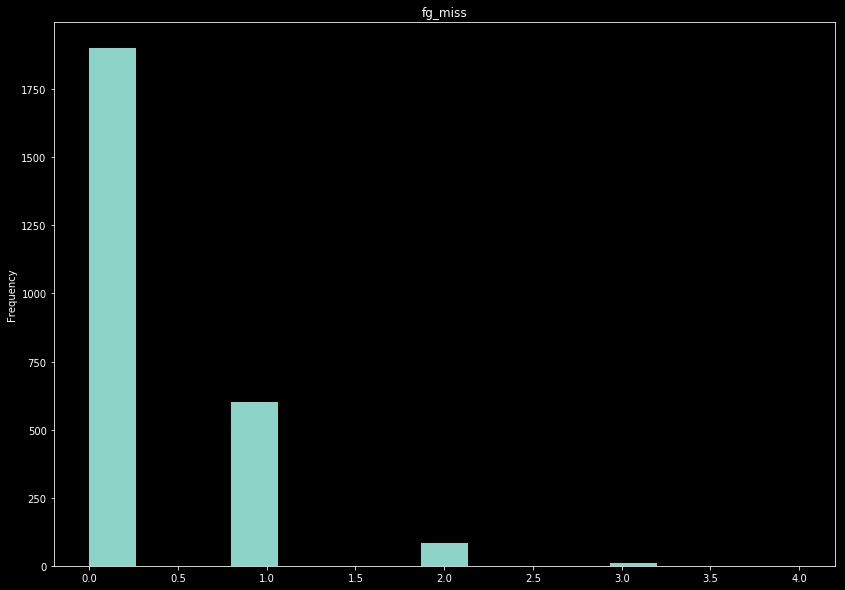

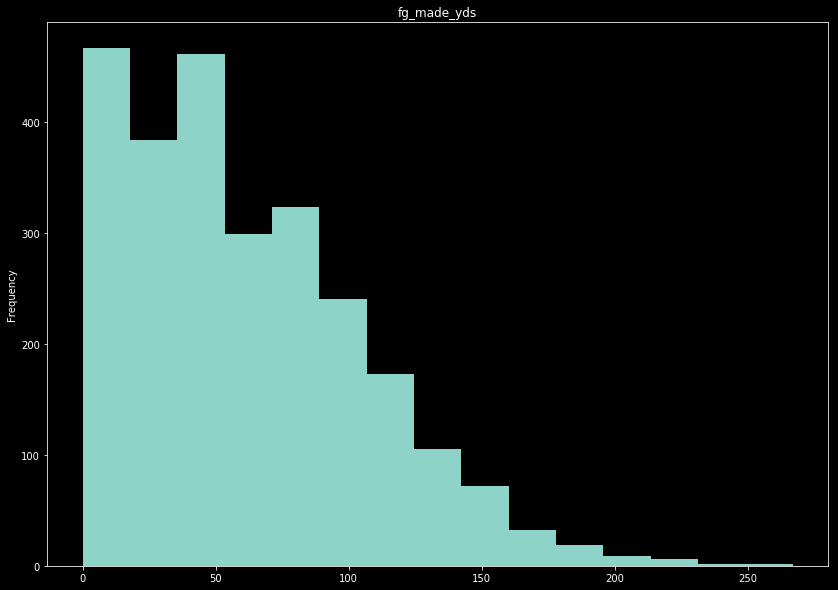

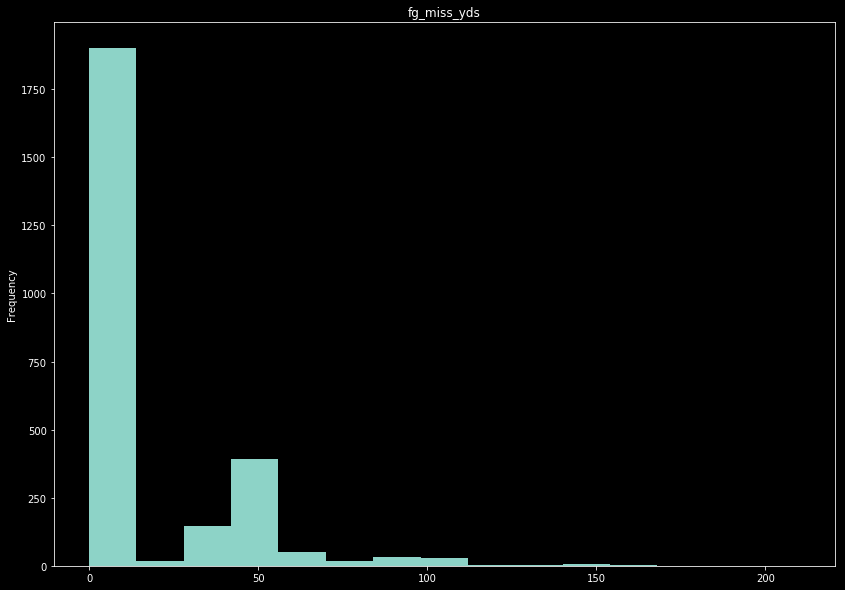

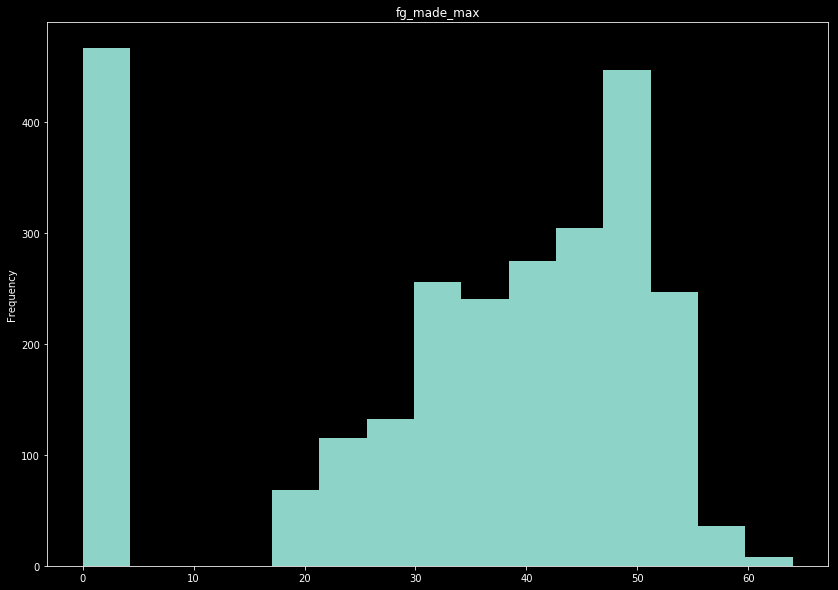

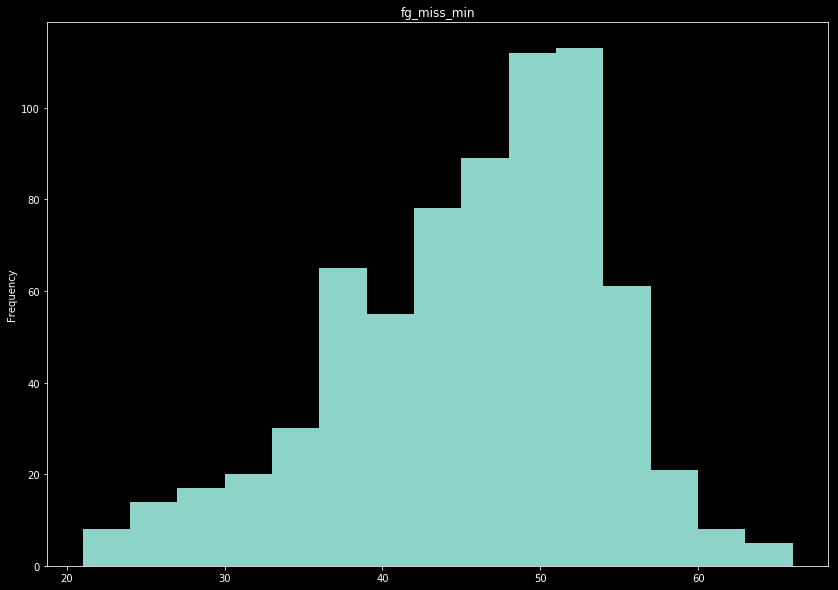

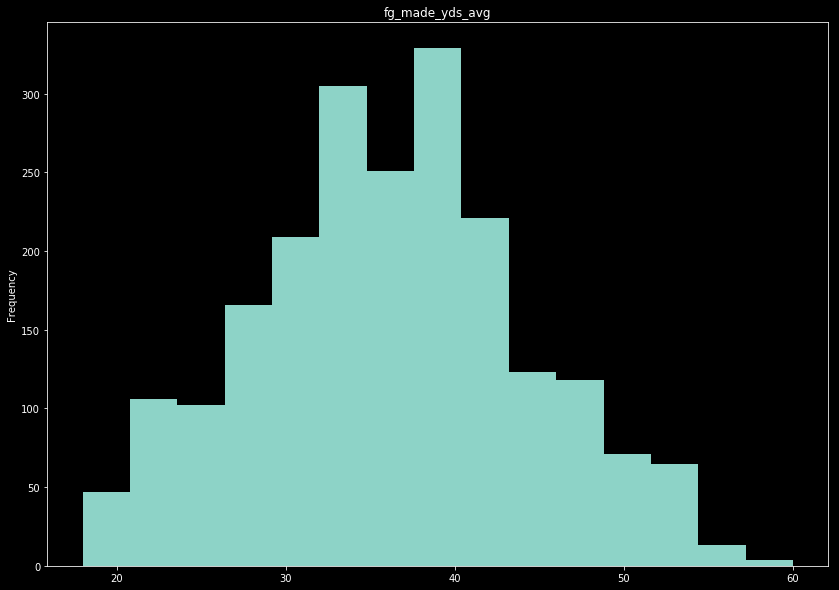

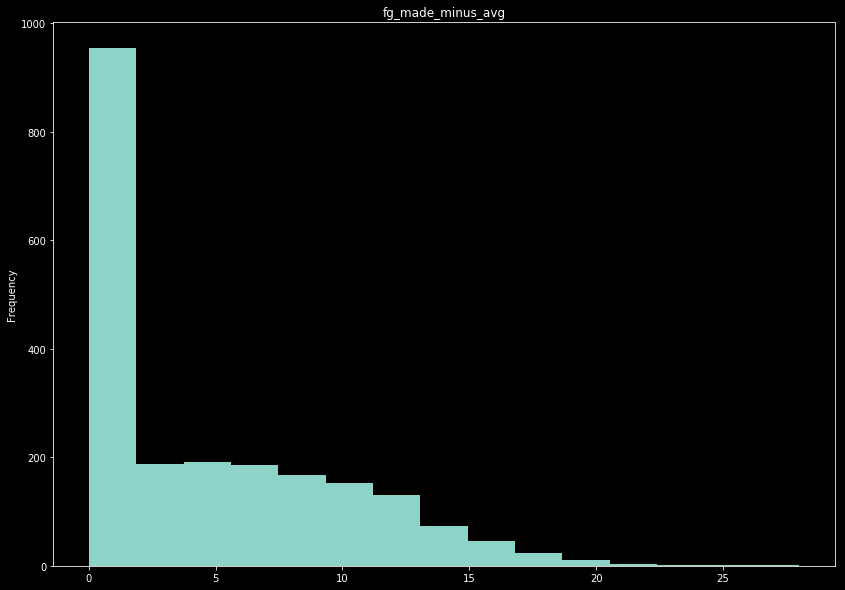

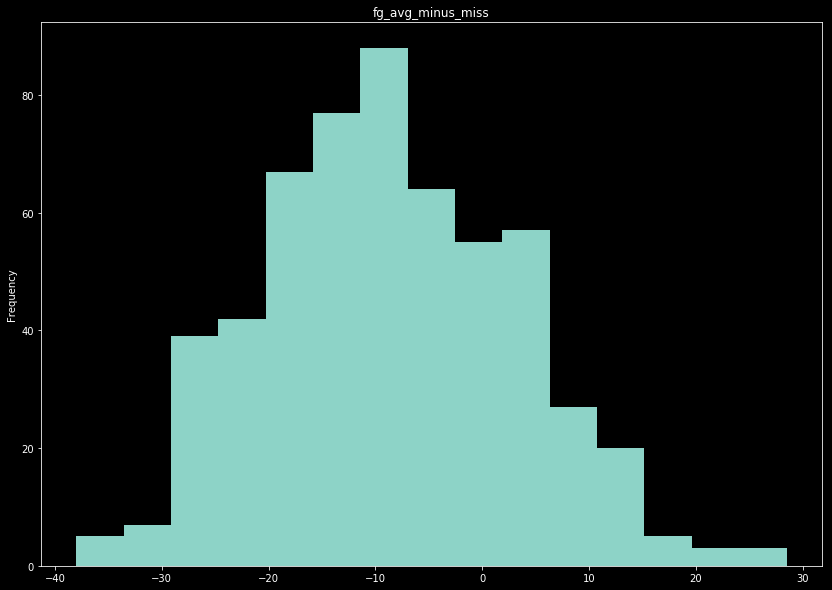

In [19]:
foo = all_kicker_data.drop(['player_id','team','week','year'],axis=1).copy()

foo['fg_made_yds_avg'  ] = foo['fg_made_yds'    ] / foo['fg_made']
foo['fg_made_minus_avg'] = foo['fg_made_max'    ] - foo['fg_made_yds_avg']
foo['fg_avg_minus_miss'] = foo['fg_made_yds_avg'] - foo['fg_miss_min']

for col in foo.columns.values:
    foo[col].plot.hist( bins=15, title=col )
    plt.show()

5 pts per 50+ yard FG made

4 pts per 40-49 yard FG made

3 pts per FG made, 39 yards or less

2 pts per rushing, passing, or receiving 2 pt conversion

1 pt per Extra Point made

Penalty Points

-2 pts per missed FG (0-39 yds)

-1 pt per missed FG (40-49 yds)

(note: a missed FG includes any attempt that is blocked, deflected, etc.)

In [6]:
print all_kicker_data.loc[all_kicker_data['xp_made']>0]['xp_made'].sum()
print all_kicker_data.loc[all_kicker_data['xp_miss']>0]['xp_miss'].sum()

5564
138


Ignore xp stuff, it's easy enough to get. Just predict from team's touchdowns

In [7]:
print all_kicker_data.loc[all_kicker_data['fg_made_max']>=50].shape
print all_kicker_data.loc[all_kicker_data['fg_made_max']< 50].shape

(443, 13)
(2154, 13)


In [14]:
print all_kicker_data.loc[all_kicker_data['fg_miss_min'].isnull()].shape
print all_kicker_data.loc[all_kicker_data['fg_miss_min'].notnull()].shape

(1901, 12)
(696, 12)


Should handle carfully. 

Consider timeframes to store min/max?

Measure relative to avg yardage?

In [11]:
team_df.columns.values

array([u'team', 'opp_team', u'week', 'year', 'score', 'opp_score',
       'home_flag', 'away_flag', 'tds', 'rush_att', 'rush_yds', 'pass_att',
       'pass_yds', 'pass_cmp', 'pass_sack', 'kickoffs', 'punts', 'fg_miss',
       'fumbles', 'kickoff_in_20', 'kickoff_touchback', 'fg_yds',
       'fg_made', 'def_score_flag', 'def_tkl', 'def_tkl_contributers',
       u'def_fumb_forced', u'def_int', u'def_tkl_loss', 'def_sack',
       'def_pass_def', 'opp_rush_att', 'opp_rush_yds', 'opp_pass_att',
       'opp_pass_yds', 'opp_pass_cmp', 'opp_pass_sack', 'opp_kickoffs',
       'opp_punts', 'opp_fumbles', 'opp_def_tkl',
       'opp_def_tkl_contributers', 'opp_def_sack', 'opp_def_pass_def'], dtype=object)

In [8]:
team_stuff = [
                'tds',
                'punts',
                'kickoff_in_20', 
                'kickoff_touchback',
                'fg_yds',
                'fg_made',
                'fg_miss'
             ]